In [2]:
import os
import re
import glob
import json
import gzip
import torch
import open_clip
import pandas as pd
import pickle as pk
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from tqdm import tqdm

In [3]:
def make_metrics(conf, freqs):
    out = {}
    accs, preds = conf.diagonal() / conf.sum(axis=1), conf.sum(axis=0)
    top1 = conf.diagonal().sum() / conf.sum()
    corr_acc, corr_pred = spearmanr(freqs, accs).statistic, spearmanr(freqs, preds).statistic,
    out['top1'] = top1 * 100
    out['corr_acc'], out['corr_pred'] = corr_acc, corr_pred
    return out

def parse_pretrain(pretrained):
    if 'cc12m' in pretrained:
        dataset = 'CC-12M'
    elif 'yfcc15m' in pretrained:
        dataset = 'YFCC-15M'
    elif 'metaclip_400m' in pretrained:
        dataset = 'MetaCLIP-400M'
    elif 'metaclip_fullcc' in pretrained:
        dataset = 'MetaCLIP-2.5B'
    elif 'laion400m' in pretrained:
        dataset = 'LAION-400M'
    elif 'laion2b' in pretrained:
        dataset = 'LAION-2B'
    else:
        dataset = 'LAIONet-3M'
    return dataset

def parse_downstream(ds):
    if 'cub' in ds:
        dataset = 'CUB'
    elif 'food101' in ds:
        dataset = 'Food-101'
    elif 'pets' in ds:
        dataset = 'Oxford Pets'
    elif 'flowers102' in ds:
        dataset = 'Flowers-102'
    elif 'places365' in ds:
        dataset = 'Places-365'
    elif 'eurosat' in ds:
        dataset = 'EuroSAT'
    elif 'dtd' in ds:
        dataset = 'DTD'
    else:
        raise NotImplementedError
    return dataset

def parse_model(model):
    if 'RN' in model:
        model = 'ResNet'
    elif 'convnext' in model:
        model = 'ConvNeXt'
    elif 'ViT' in model:
        model = 'ViT'
    elif 'EVA' in model:
        model = 'EVA'
    else:
        raise NotImplementedError
    return model

downstreams = ['cub', 'food101', 'pets', 'flowers102', 'places365', 'eurosat', 'dtd']
pretrains = ["cc12m", "yfcc15m", "laion400m", "metaclip_400m", "laion2b", "metaclip_fullcc"]
pretrain2freqs = {}
for pretrain in pretrains:
    pt = parse_pretrain(pretrain)
    freqs = {}
    for downstream in downstreams:
        ds = parse_downstream(downstream)
        class_names = list(json.load(open("../descriptors/descriptors_{}.json".format(downstream), "r")).keys())
        with open("../metadata/freqs/class_frequency_{}_{}.txt".format(pretrain, downstream)) as f:
            lines = f.readlines()
            class_frequencies = {line.strip().split('\t')[0]: int(line.strip().split('\t')[1]) for line in lines}
        frequencies = [class_frequencies[class_name] for class_name in class_names]
        freqs[ds] = frequencies
    pretrain2freqs[pt] = freqs

# Obtaining the results requires flexible evaluation of CLIP using any pre-trained model on any downstream dataset
# Our results are obtained from a customized version of this repo: https://github.com/ExplainableML/WaffleCLIP
# For replication, download the confusion matrices of each evaluation run here: https://drive.google.com/file/d/1bvENXvEyx87aFx0ftBnsY3XUpZ6xMu9k/view?usp=sharing
def get_metrics(models, root='../confusions/confmat_clip_{}_{}.{}_normal.npy.gz'):
    metrics = []
    for model, pretrained in models:
        if 'EVA' in model:
            continue
        for downstream in downstreams:
            path = root.format(downstream, model, pretrained)
            if os.path.exists(path):
                conf = np.load(gzip.GzipFile(path, 'r'))
                backbone, pt, ds = parse_model(model), parse_pretrain(pretrained), parse_downstream(downstream)
                freqs = pretrain2freqs[pt][ds]
                df_dict = {'Model': 'CLIP', 'Backbone': backbone, 'Pretrain': pt, 'Downstream': ds}
                df_dict.update(make_metrics(conf, freqs))
                metrics.append(pd.DataFrame(df_dict, index=[0]))
    metrics = pd.concat(metrics)
    metrics = metrics.reset_index(drop=True)
    return metrics

In [4]:
models = open_clip.list_pretrained()
models = [item for item in models if 'cc12m' in item[1] or 'yfcc15m' in item[1] or 'laion400m' in item[1] or 'laion2b' in item[1] or 'metaclip' in item[1]]
metrics = get_metrics(models)

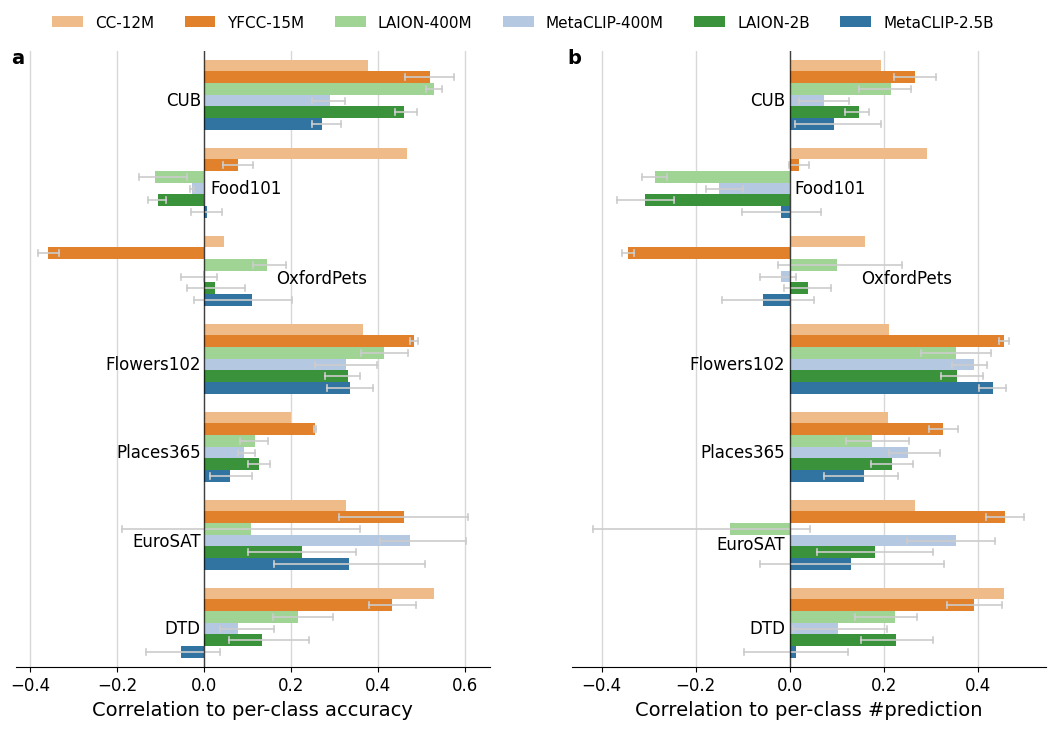

In [5]:
palette = sns.color_palette('tab20')
palette = [palette[3], palette[2], palette[5], palette[1], palette[4], palette[0]]
datasets = ['CC-12M', 'YFCC-15M', 'LAION-400M', 'MetaCLIP-400M', 'LAION-2B', 'MetaCLIP-2.5B']
downstreams = ['CUB', 'Food101', 'OxfordPets', 'Flowers102', 'Places365', 'EuroSAT', 'DTD']

fig, ax = plt.subplots(1, 2, sharey=False, figsize=(14, 8))
# frame off
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.7, zorder=10)
ax[0].grid(axis='x', color='gray', linestyle='-', linewidth=1, alpha=0.3, zorder=0)
ax[1].axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.7, zorder=10)
ax[1].grid(axis='x', color='gray', linestyle='-', linewidth=1, alpha=0.3, zorder=0)

poses1 = [.4] * 7
poses2 = [.46] * 7
shifts1 = [-.01, .01, .15, -.01, -.01, -.01, -.01]
shifts2 = [-.01, .01, .15, -.01, -.01, -.01, -.01]
yshifts1 = [.06, .06, .08, .06, .06, .07, .06]
yshifts2 = [.06, .06, .08, .06, .06, .11, .06]
has1 = ['right', 'left', 'left', 'right', 'right', 'right', 'right']
has2 = ['right', 'left', 'left', 'right', 'right', 'right', 'right']

# reorder datasets by the order of the list datasets
metrics = metrics.set_index('Pretrain').loc[datasets].reset_index()
sns.barplot(data=metrics, y='Downstream', x='corr_acc' , hue='Pretrain', palette=palette, ax=ax[0], zorder=2, orient='y', width=.8, capsize=.4, err_kws={"color": ".8", "linewidth": 1.2})
sns.barplot(data=metrics, y='Downstream', x='corr_pred', hue='Pretrain', palette=palette, ax=ax[1], zorder=2, orient='y', width=.8, capsize=.4, err_kws={"color": ".8", "linewidth": 1.2})

for i, ds in enumerate(downstreams):
    ax[0].text(poses1[i]+shifts1[i], i+yshifts1[i], ds, va='center', ha=has1[i], transform=ax[0].get_yaxis_transform(), rotation=0, fontsize=12)
    ax[1].text(poses2[i]+shifts2[i], i+yshifts2[i], ds, va='center', ha=has2[i], transform=ax[1].get_yaxis_transform(), rotation=0, fontsize=12)

ax[0].text(-.01, .98, 'a', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(-.01, .98, 'b', fontsize=14, fontweight='bold', transform=ax[1].transAxes)

ax[0].legend().remove()
ax[1].legend().remove()
plt.legend(ncols=6, loc='upper right', bbox_to_anchor=(.92, 1.08), frameon=False, fontsize=11)
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_xlabel('Correlation to per-class accuracy', fontsize=14)
ax[1].set_xlabel('Correlation to per-class #prediction', fontsize=14)
ax[0].xaxis.set_tick_params(labelsize=12, rotation=0)
ax[1].xaxis.set_tick_params(labelsize=12, rotation=0)

ax[0].set_box_aspect(1.3)
ax[1].set_box_aspect(1.3)
plt.subplots_adjust(hspace=0., wspace=0.05)
plt.savefig('figs/corrs_fgvc.pdf', bbox_inches='tight', dpi=300)